In [1]:
import os

import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.linalg import eig

from lib.data import raw_io as io
from lib.data import tables as tab
from lib.data import conditions as cond

In [2]:
engine = tab.sa.create_engine(os.environ['SQLALCHEMY_ENGINE_URL'])
Session = tab.sa.orm.sessionmaker(bind=engine)
session = Session()

In [3]:
average_traces = {}

for trial_kind in [cond.TrialKind.non_catch, cond.TrialKind.catch]:
    average_traces[trial_kind] = np.array([
        tr.trace[:420] for tr in 
        session.query(tab.TrialAverageTrace)
            .filter_by(day=7, trial_kind=trial_kind)
            .all()
        if not np.all(np.isnan(tr.trace))
    ])

In [4]:
for key, val in average_traces.items():
    print(f'{key} array shape: {val.shape}')

TrialKind.non_catch array shape: (3339, 420)
TrialKind.catch array shape: (3339, 420)


In [5]:
cov_matrices = {}

for trial_kind, arr in average_traces.items():
    print(f'Computing cov matrix for {trial_kind}')
    cov_matrices[trial_kind] = np.cov(arr)

Computing cov matrix for TrialKind.non_catch
Computing cov matrix for TrialKind.catch


TrialKind.non_catch array
---------------
shape: (3339, 3339)
median:   0.000173
75th percentile:   0.004439
90th percentile:   0.014008

TrialKind.catch array
---------------
shape: (3339, 3339)
median:  -0.000590
75th percentile:   0.014013
90th percentile:   0.040006



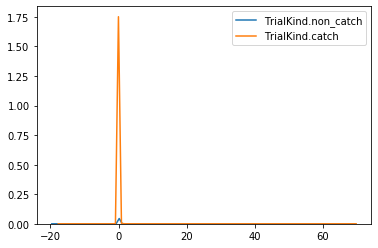

In [31]:
for key, val in cov_matrices.items():
    vals = np.triu(val)
    vals = vals[vals!=0]
    print(
        f'{key} array\n'
        '---------------\n'
        f'shape: {val.shape}\n'
        f'median: {np.percentile(vals, 50.):>10.6f}\n'
        f'75th percentile: {np.percentile(vals, 75.):>10.6f}\n'
        f'90th percentile: {np.percentile(vals, 90.):>10.6f}\n'
    )
    sns.kdeplot(vals, label=key)
plt.legend()
plt.show()
    #plt.matshow(np.log(val**2))

In [8]:
eigvals, eigvecs = eig(cov_matrices[cond.TrialKind.non_catch], cov_matrices[cond.TrialKind.catch])

/opt/miniconda3/envs/candice/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


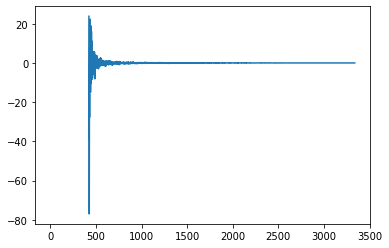

In [32]:
plt.plot(eigvals)

In [34]:
np.sum(~np.isfinite(eigvals))

421

In [36]:
np.sum(np.isclose(eigvals, 0))

/opt/miniconda3/envs/candice/lib/python3.8/site-packages/numpy/core/numeric.py:2267: RuntimeWarning: invalid value encountered in multiply
  x = x * ones_like(cond)


419

In [37]:
catch_eigvals, catch_eigvecs = eig(cov_matrices[cond.TrialKind.catch])

/opt/miniconda3/envs/candice/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


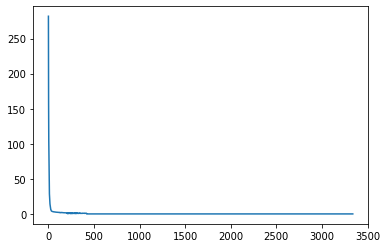

In [38]:
plt.plot(catch_eigvals)

In [39]:
np.isclose(catch_eigvals, 0).sum()

2920

In [17]:
np.linalg.matrix_rank(cov_matrices[cond.TrialKind.non_catch], hermitian=True)

419

In [18]:
np.linalg.matrix_rank(cov_matrices[cond.TrialKind.catch], hermitian=True)

419

/opt/miniconda3/envs/candice/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


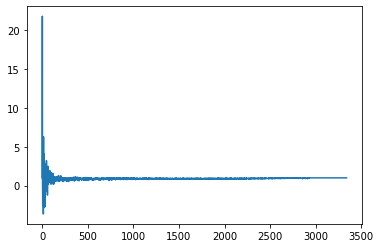

In [24]:
plt.plot(eigvals)

In [25]:
order = np.argsort(eigvals)

/opt/miniconda3/envs/candice/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


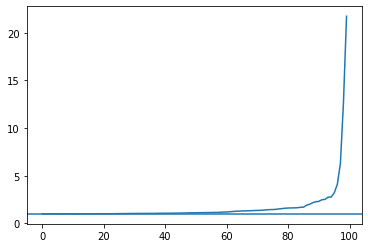

In [29]:
plt.axhline(1)
plt.plot(eigvals[order][-100:])

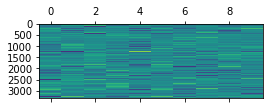

In [37]:
plt.matshow(eigvecs[:, order][:, -10:], aspect=0.0010)

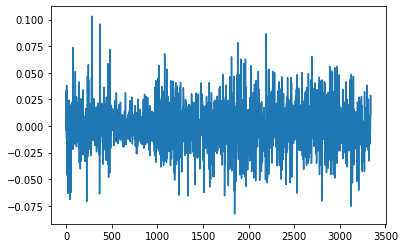

In [38]:
plt.plot(eigvecs[:, order][:, -1])

In [39]:
weights = eigvecs[:, order][:, -1:-40:-1]

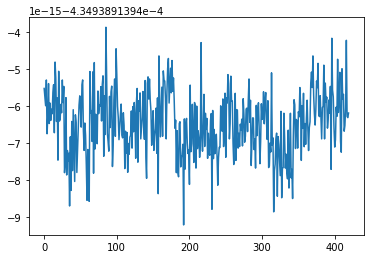

In [41]:
plt.plot(np.dot(weights[:, 0], average_traces[cond.TrialKind.non_catch]))

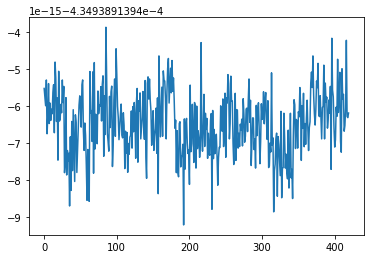

In [43]:
plt.plot(np.dot(weights[:, 0], average_traces[cond.TrialKind.catch]))

In [47]:
np.array_equal(average_traces[cond.TrialKind.non_catch], average_traces[cond.TrialKind.catch])

True